In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
from torchvision import transforms

# Define the main directory containing subfolders
IMG_LOC = r"C:\Users\avs20\Documents\GitHub\facemap\data\schroeder_individual_folders"

# Path to save the new images, labels, and CSV file
output_dir = r"C:\Users\avs20\Documents\GitHub\facemap\data\processed_images_labels"
os.makedirs(output_dir, exist_ok=True)

# Prepare a list to store the new keypoints for CSV
new_keypoints = []

# Function to apply random crop and resize to 224x224
def random_crop_and_resize(img, keypoints, target_size=224):
    # Get the original image size
    img = img.convert("L")  # Convert to grayscale (1 channel) - just remove this line to get the image in RGB
    img_width, img_height = img.size
    
    # Find the shortest side
    crop_size = min(img_width, img_height)
    
    # Randomly choose the top-left corner for the crop
    left = random.randint(0, img_width - crop_size)
    top = random.randint(0, img_height - crop_size)
    
    # Apply the crop
    img_cropped = img.crop((left, top, left + crop_size, top + crop_size))
    
    # Resize the cropped image to 224x224
    img_resized = img_cropped.resize((target_size, target_size))
    
    # Adjust the keypoints based on the crop and resize
    # Adjust for the crop (shift the keypoints by the crop's top-left corner)
    adjusted_keypoints = []
    for i in range(0, len(keypoints), 2):
        x = keypoints[i] - left
        y = keypoints[i + 1] - top
        adjusted_keypoints.append(x)
        adjusted_keypoints.append(y)
    
    # Adjust for the resizing (scale keypoints to the new image size)
    scale_x = target_size / crop_size
    scale_y = target_size / crop_size
    
    adjusted_keypoints = [
        adjusted_keypoints[i] * scale_x if i % 2 == 0 else adjusted_keypoints[i] * scale_y
        for i in range(len(adjusted_keypoints))
    ]
    
    return img_resized, adjusted_keypoints

# Prepare lists to store data to be saved
all_images = []
all_labels = []
all_filenames = []

# Loop through each subfolder
for subfolder in os.scandir(IMG_LOC):
    if subfolder.is_dir():
        subfolder_path = subfolder.path
        
        # Get all image files in the current subfolder (filtering out non-image files)
        image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        
        # Check if there are images in the folder
        if not image_files:
            continue
        
        # Check for the presence of a CSV file in the subfolder
        csv_files = [f for f in os.listdir(subfolder_path) if f.endswith('.csv')]
        if csv_files:
            csv_path = os.path.join(subfolder_path, csv_files[0])  # Assuming one CSV per subfolder
            labels_o = pd.read_csv(csv_path)

            # Process the CSV: Skip first two rows and select relevant columns
            labels_o = labels_o.iloc[2:, 2:]
            target_o = labels_o.iloc[:, 1:].values
            target_o = np.array(target_o, dtype=np.float32)
            #print(f"Processed labels for subfolder: {os.path.basename(subfolder_path)}")
        else:
            print(f"No CSV file found for subfolder: {os.path.basename(subfolder_path)}")
            target_o = None  # Set to None if no CSV is found

        # Loop through each image in the folder and process it
        for i, image_file in enumerate(image_files):
            # Construct the full image path
            image_path = os.path.join(subfolder_path, image_file)
            
            # Open the image
            img = Image.open(image_path)
            

            
            # Get corresponding keypoints from target_o
            label = target_o[i] if target_o is not None else None
            
            # Apply random crop and resize the image and keypoints
            img_resized, adjusted_keypoints = random_crop_and_resize(img, label)
            
            # Save the resized image to the output folder
            output_image_path = os.path.join(output_dir, f"{os.path.basename(subfolder_path)}_{image_file}")
            img_resized.save(output_image_path)
            
            # Append the image and its label
            all_images.append(transforms.ToTensor()(img_resized))  # Convert image to tensor
            all_labels.append(np.array(adjusted_keypoints, dtype=np.float32))  # Convert keypoints to numpy array
            all_filenames.append(output_image_path)  # Keep track of the filenames
            
            # Store the adjusted keypoints for CSV
            new_keypoints.append(adjusted_keypoints)

# Convert lists to tensors
all_images_tensor = torch.stack(all_images)  # Stack images into a single tensor
all_labels_tensor = torch.tensor(all_labels)  # Convert labels to tensor

# Save the images and labels as a .pt file
save_path = os.path.join(output_dir, "schroeder_test.pt")
print(all_images_tensor.shape)

print(all_labels[:5])  # Print the first 5 labels to check their content
print(type(all_labels))  # Ensure it's a list

torch.save({
    'images': all_images_tensor,
    'labels': all_labels_tensor
#    'filenames': all_filenames
}, save_path)

print(f"Data saved to {save_path}")

# Save the new keypoints as a CSV file
keypoints_df = pd.DataFrame(new_keypoints)
csv_save_path = os.path.join(output_dir, "labels.csv")
keypoints_df.to_csv(csv_save_path, index=False, header=False)  # No header, just the keypoints

print(f"New keypoints saved to {csv_save_path}")


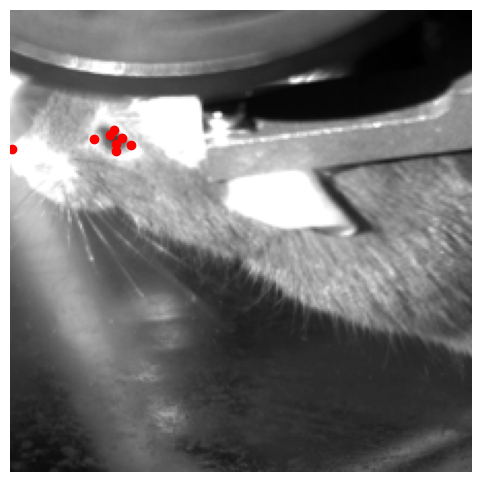

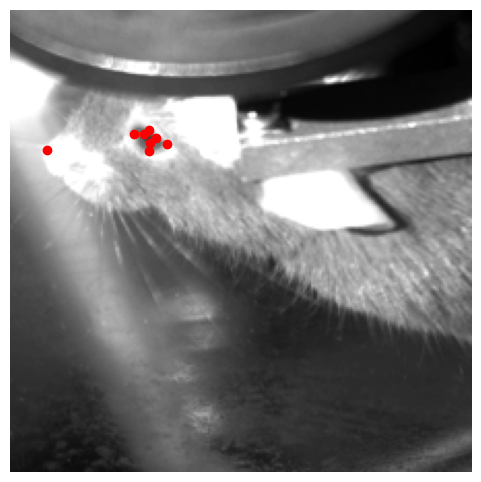

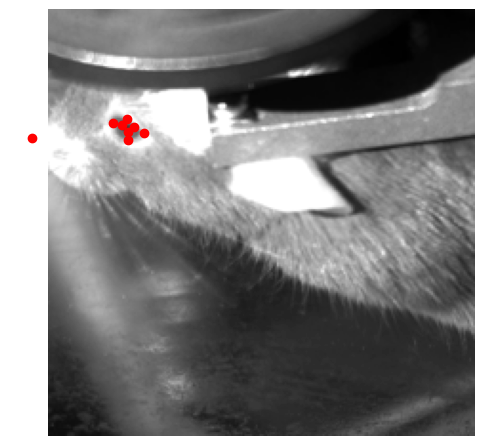

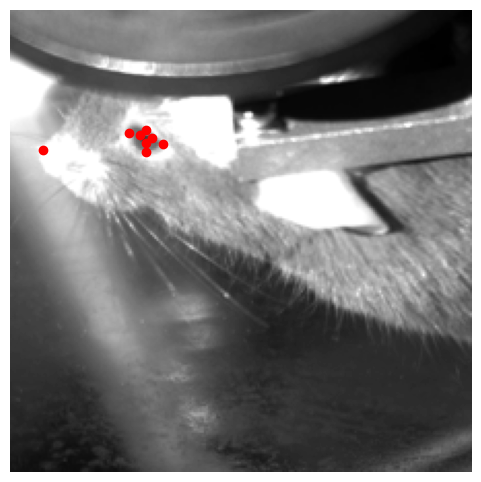

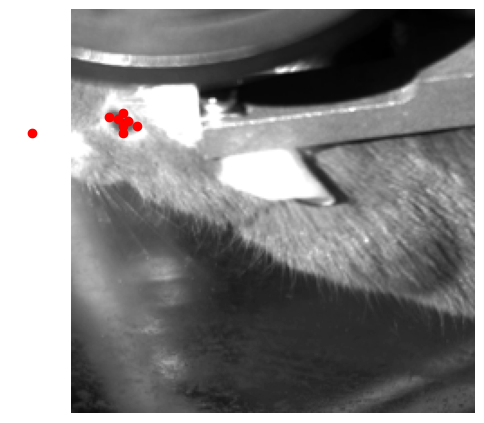

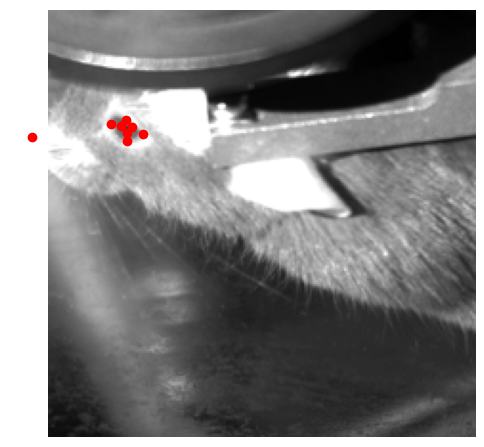

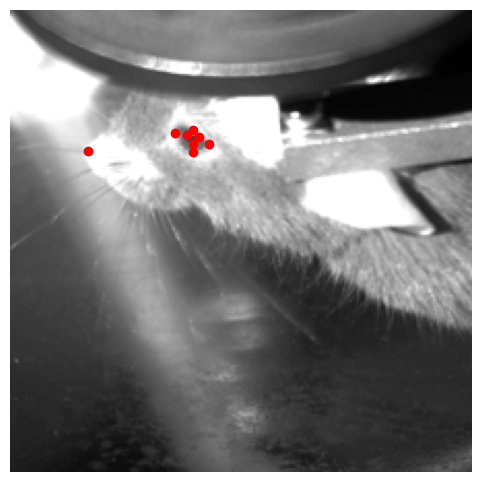

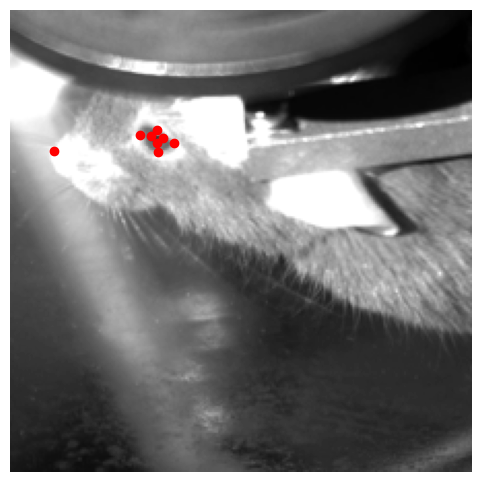

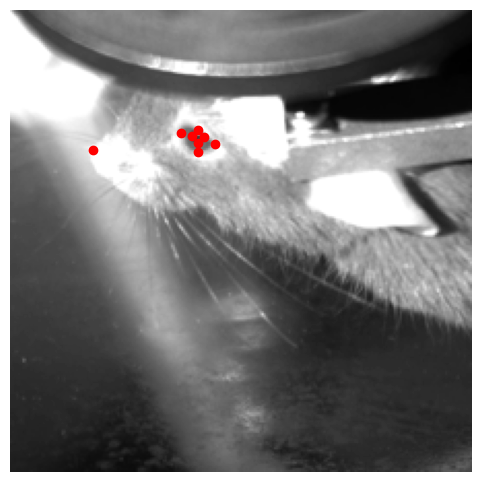

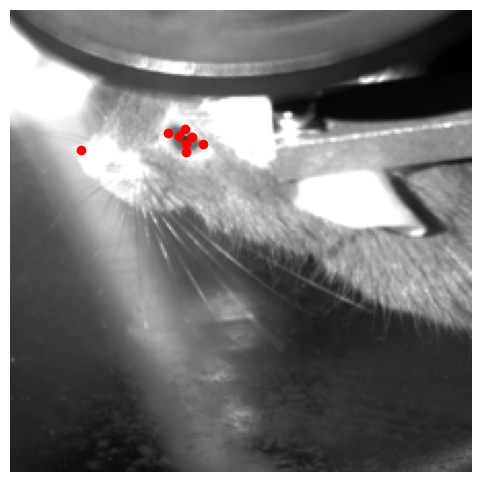

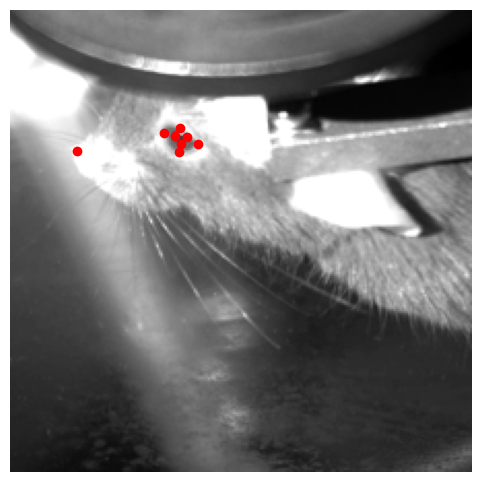

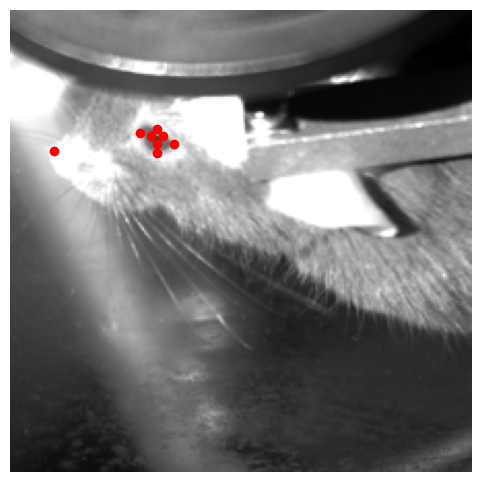

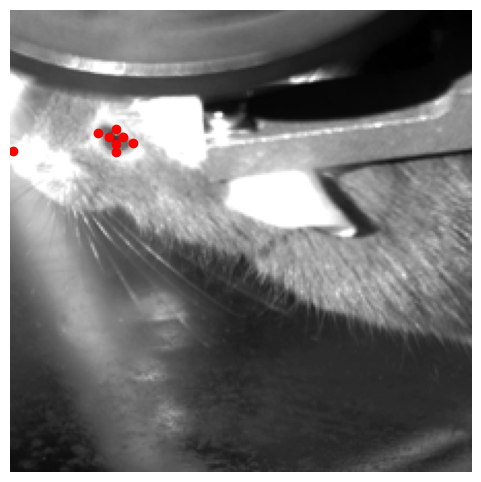

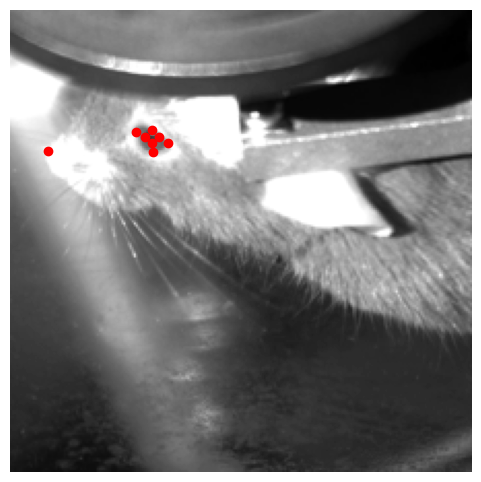

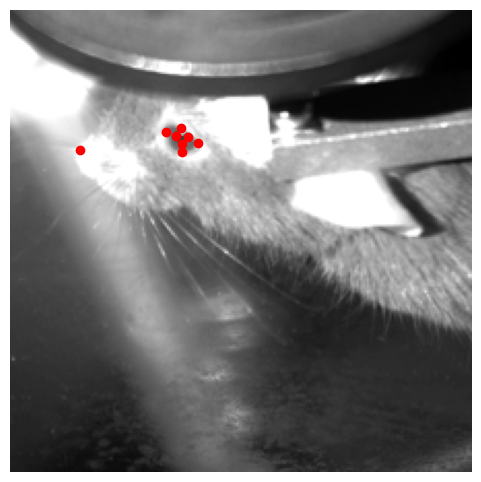

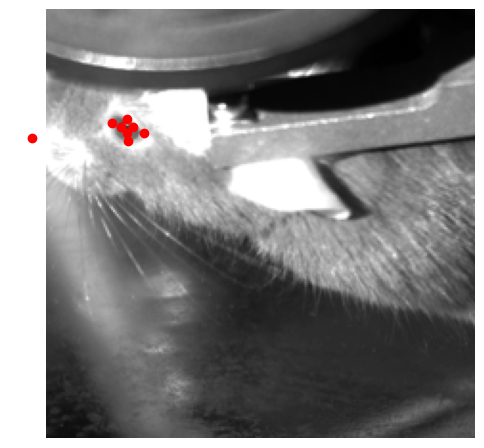

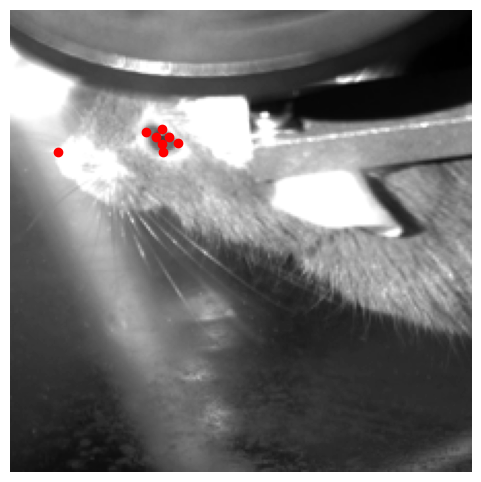

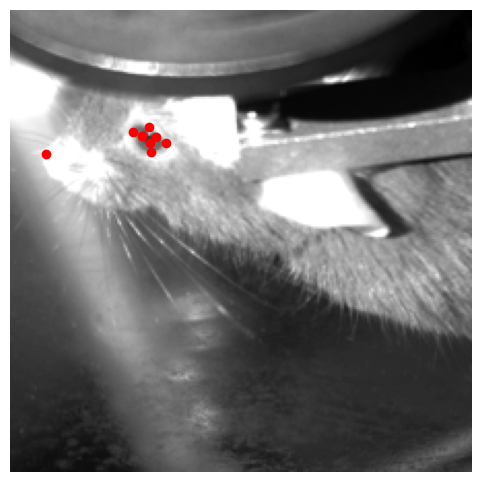

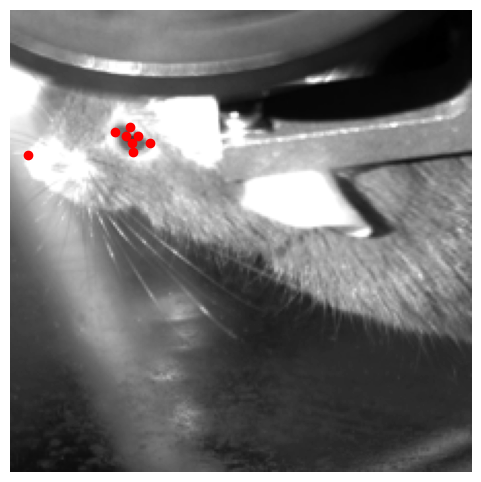

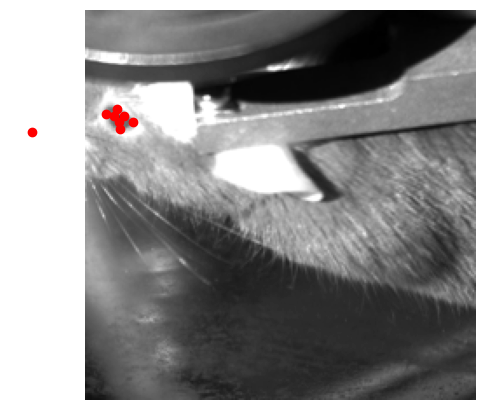

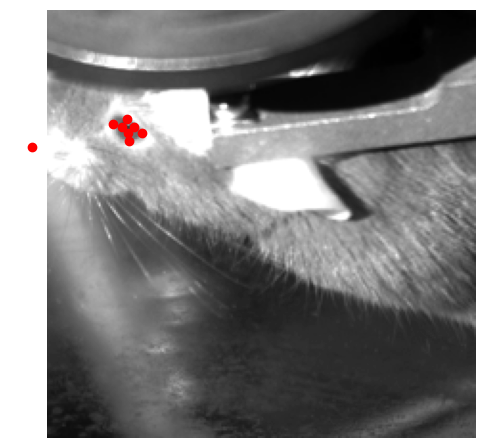

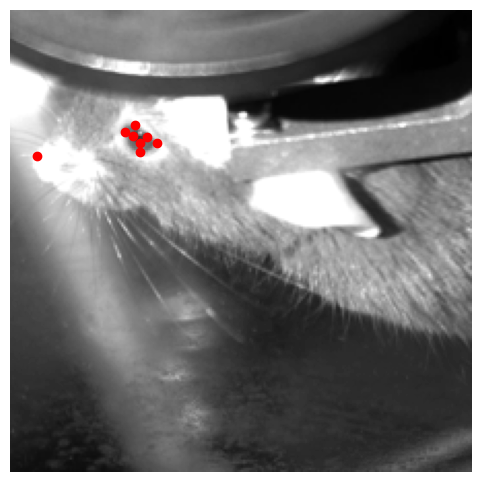

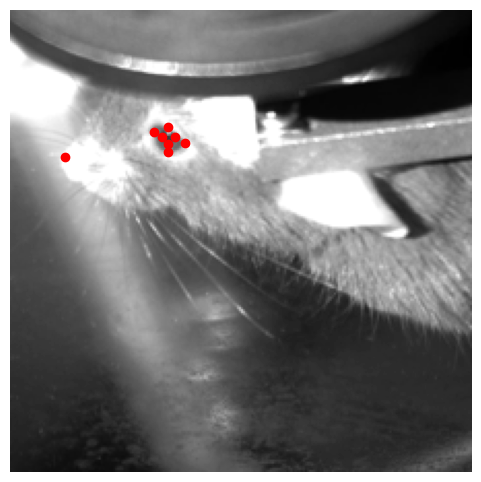

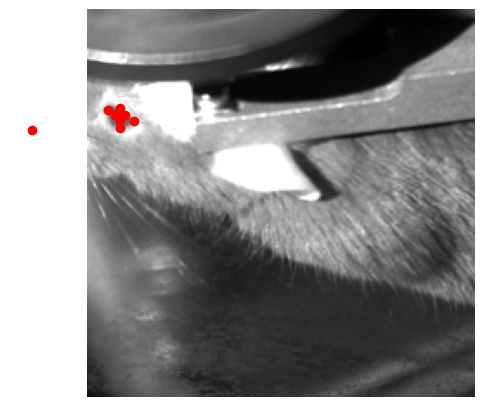

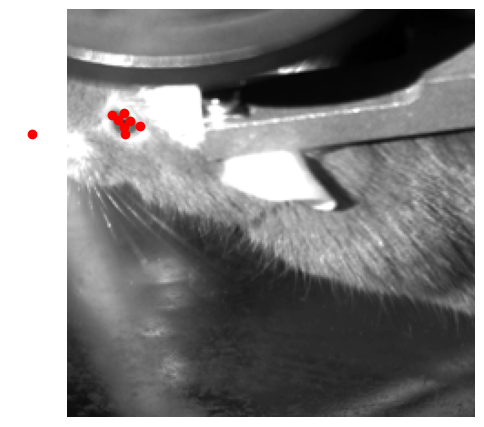

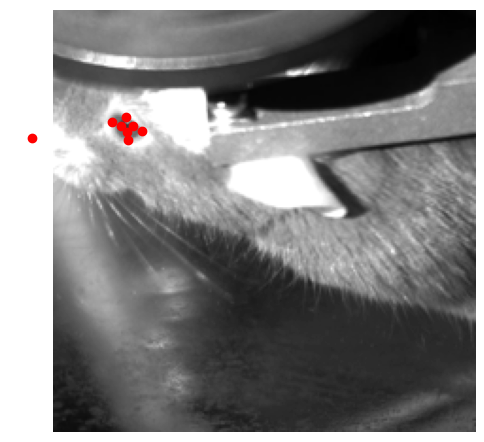

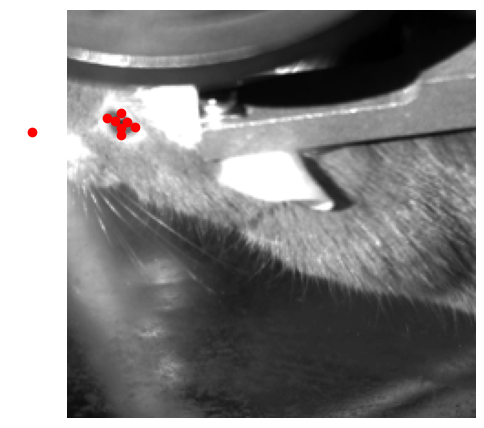

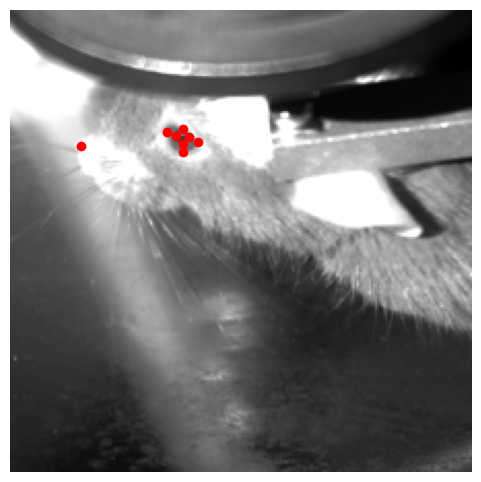

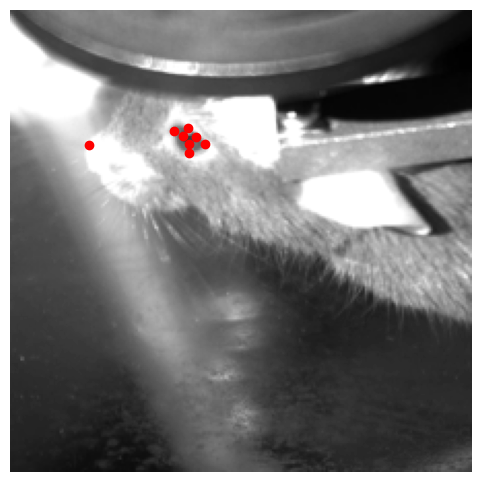

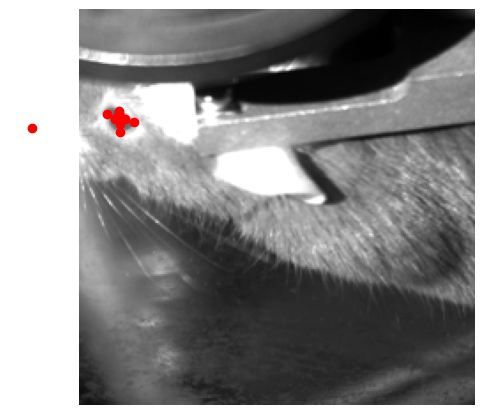

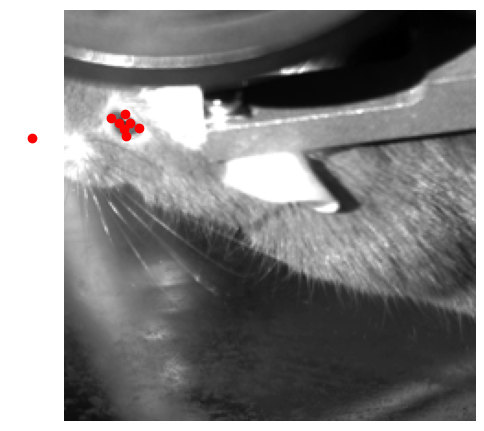

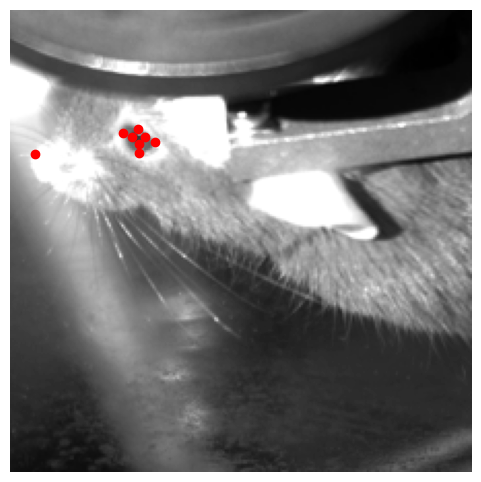

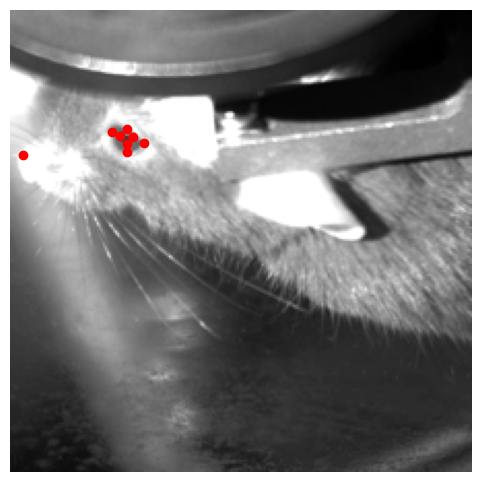

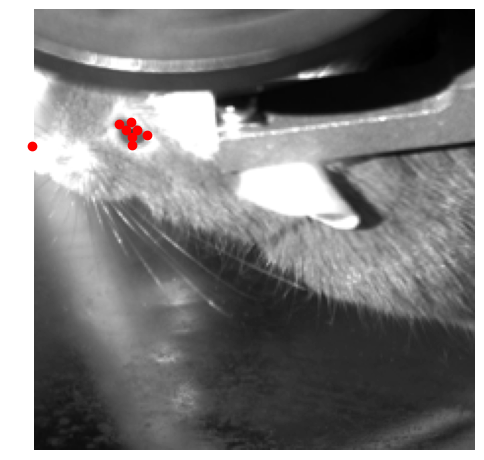

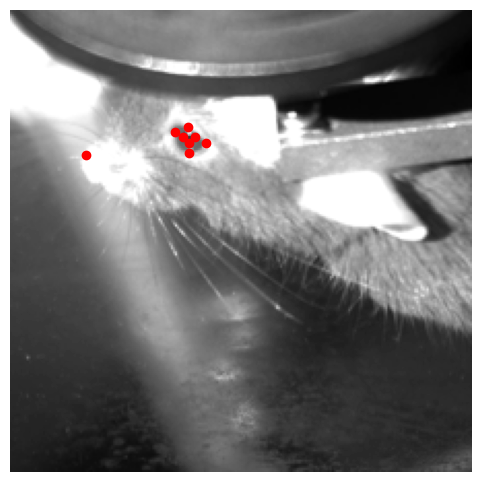

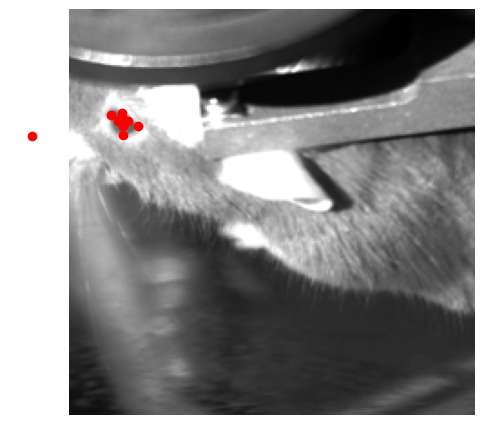

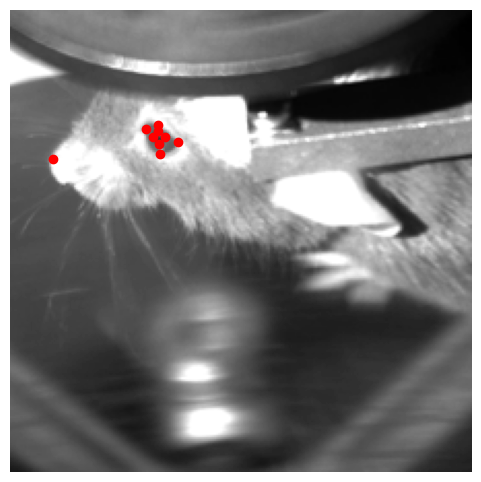

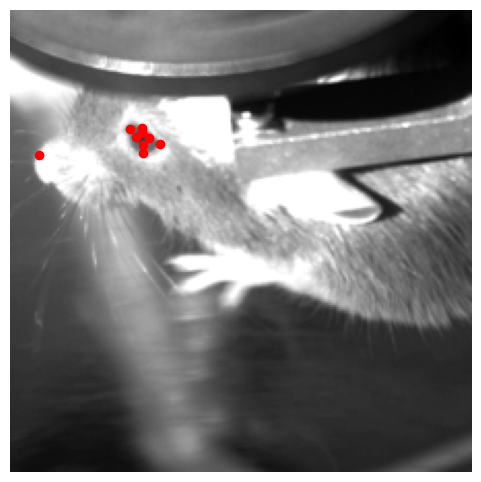

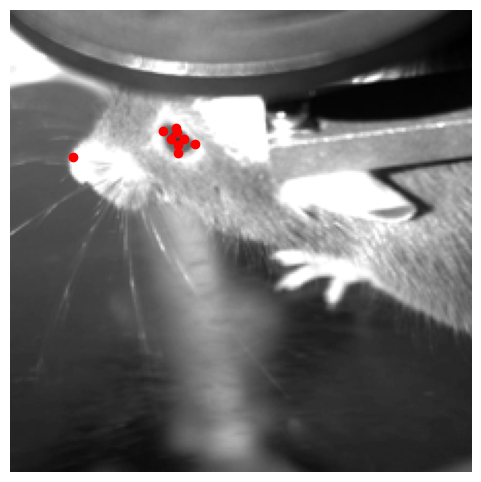

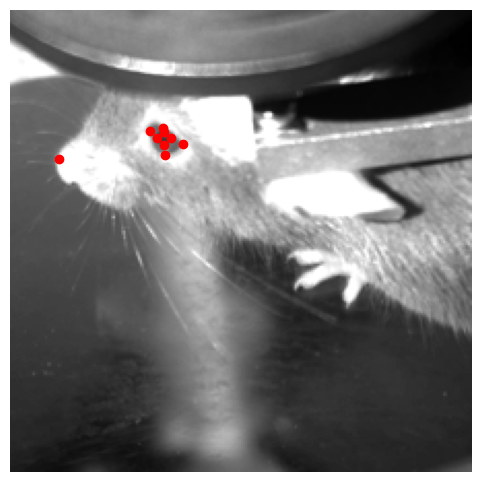

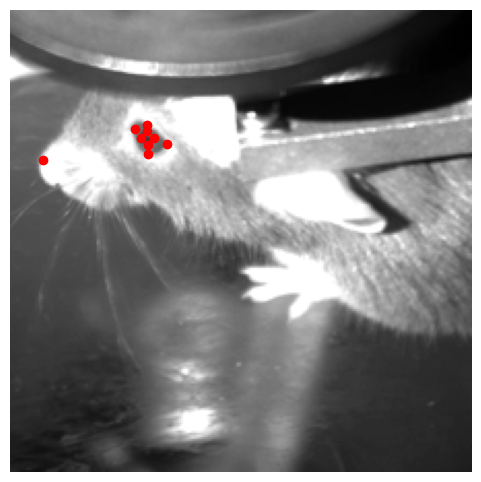

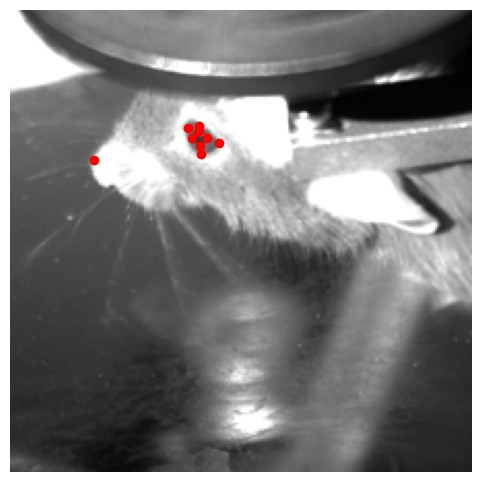

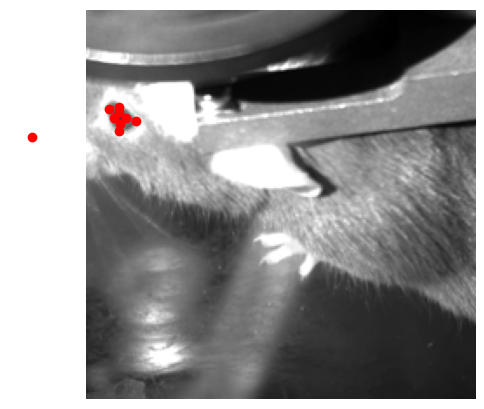

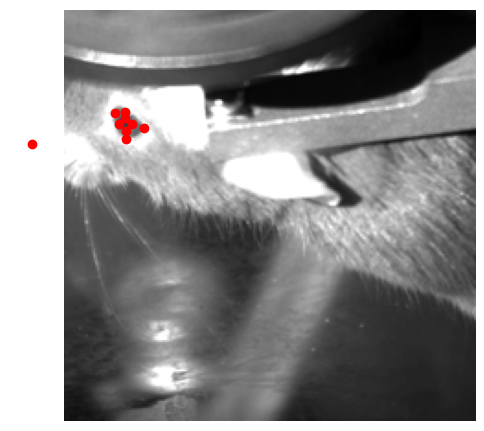

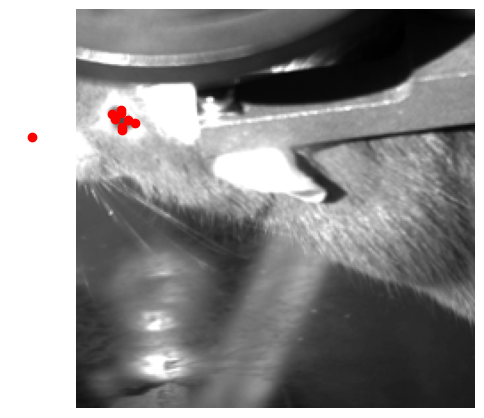

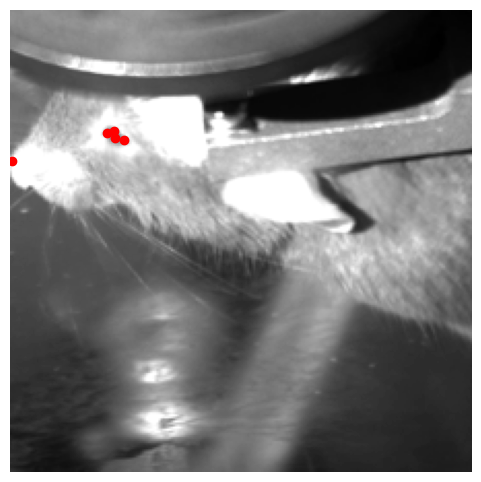

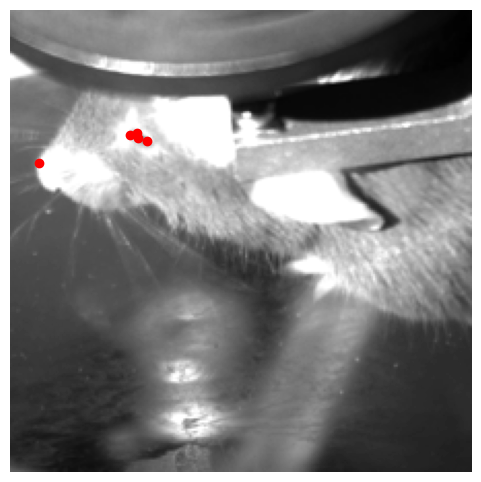

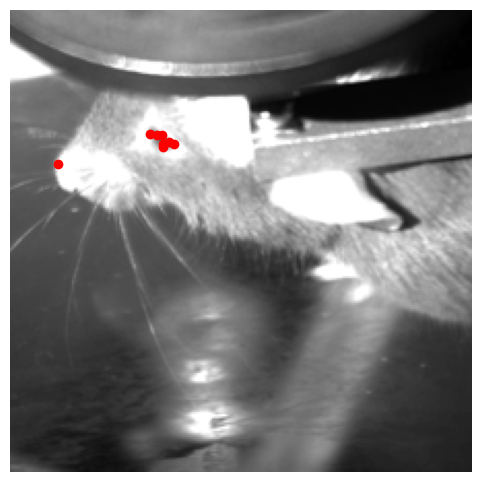

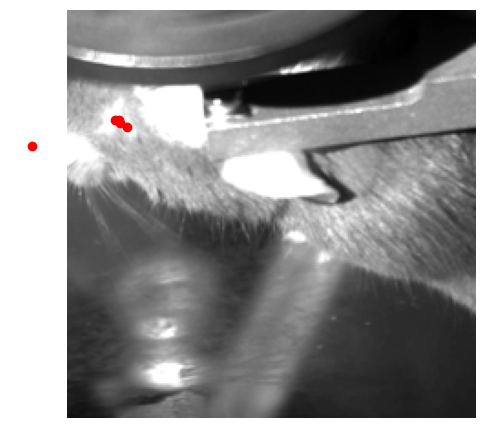

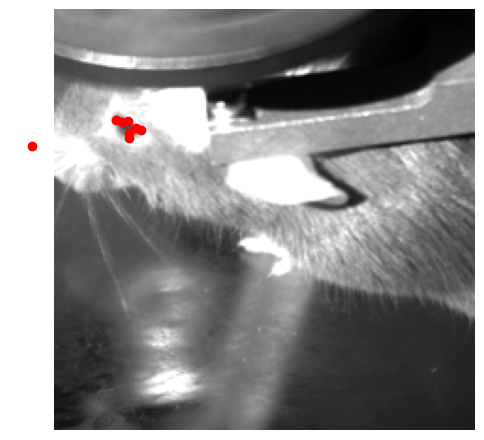

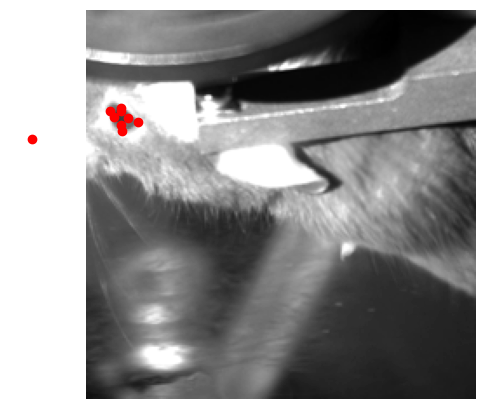

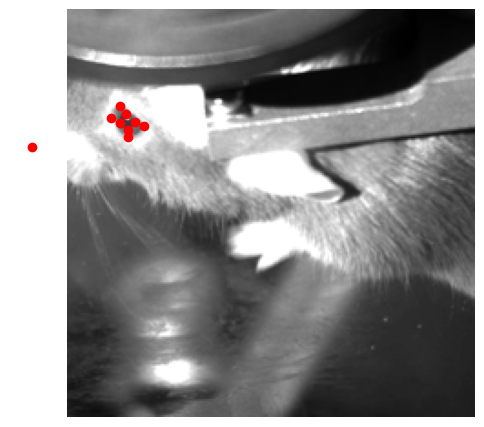

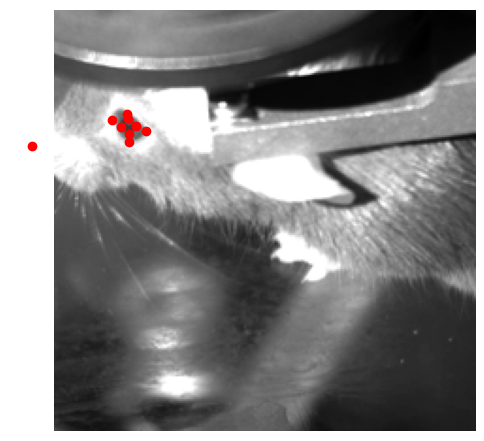

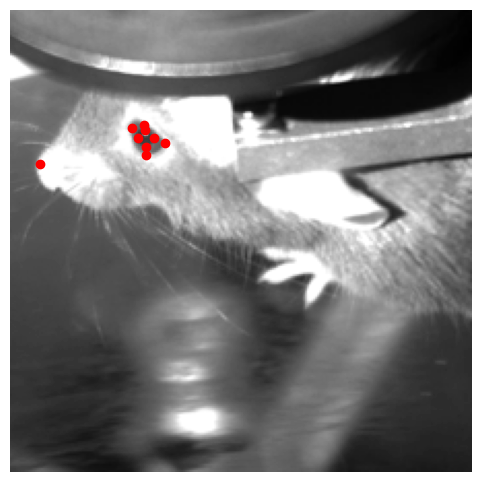

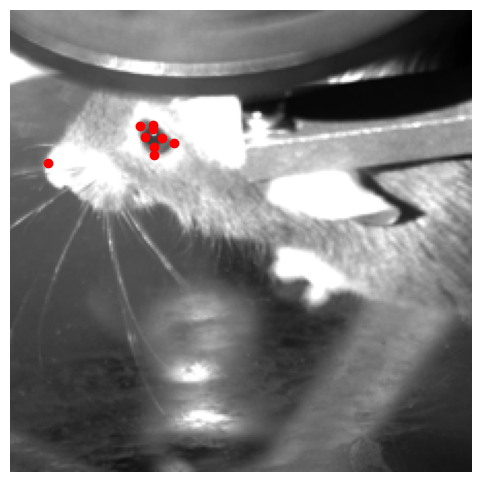

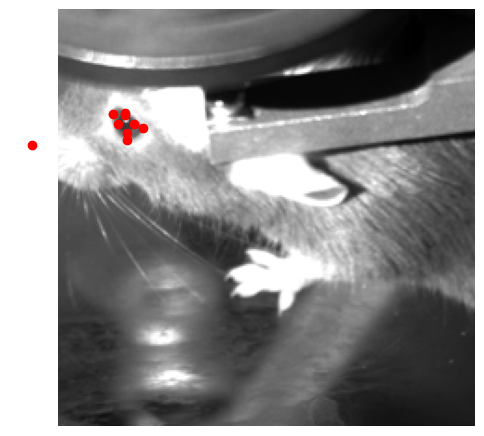

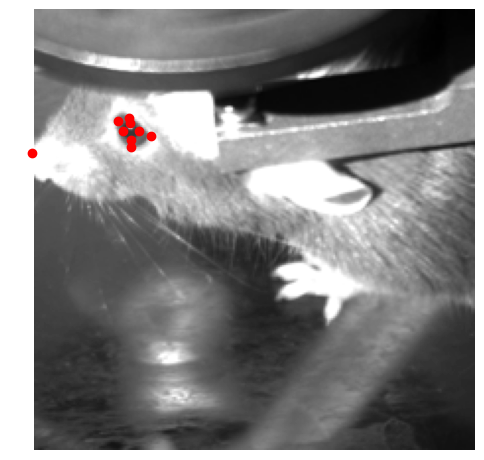

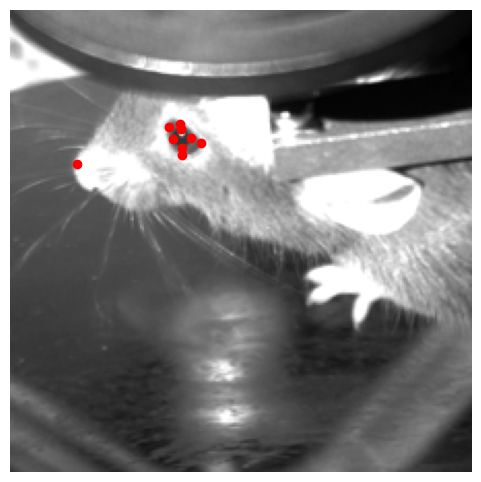

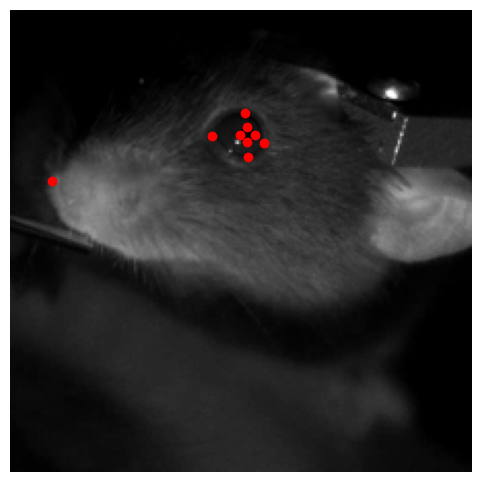

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

# Define the path to the saved .pt file
pt_file_path = r"C:\Users\avs20\Documents\GitHub\facemap\data\processed_images_labels\schroeder_test.pt"

# Load the data from the .pt file
data = torch.load(pt_file_path)

# Extract images, labels, and filenames from the loaded data
images = data['images']  # Tensor of images
labels = data['labels']  # Tensor of keypoints (shape: N x 2*K)
#filenames = data['filenames']  # List of filenames

print(images.shape)
print(labels.shape)

# Function to visualize a grayscale image with its keypoints
def visualize_image_with_keypoints(img_tensor, keypoints):
    # Convert the tensor image back to a numpy array (assuming it's in [0, 1] range)
    # Grayscale images are single-channel, so we need to handle that.
    if img_tensor.ndimension() == 3 and img_tensor.size(0) == 1:  # Shape: (1, H, W)
        img = img_tensor.squeeze(0).numpy()  # Remove channel dimension
    elif img_tensor.ndimension() == 2:  # Shape: (H, W)
        img = img_tensor.numpy()
    else:
        raise ValueError(f"Unexpected image dimensions: {img_tensor.shape}")

    # Create a matplotlib figure
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap="gray")  # Use grayscale colormap
    plt.axis('off')  # Hide axes

    # Plot the keypoints
    if keypoints is not None:
        # The keypoints are stored as [x1, y1, x2, y2, ..., xK, yK], so we split them
        xs = keypoints[0::2]  # x coordinates (even indices)
        ys = keypoints[1::2]  # y coordinates (odd indices)

        # Plot the keypoints as red circles
        plt.scatter(xs, ys, c="red", marker="o")

    # Show the image
    plt.show()

# Loop through the images and visualize them with keypoints
for i in range(len(images)):
    img_tensor = images[i]  # Get the image tensor
    keypoints = labels[i].numpy()  # Get the corresponding keypoints

    # Visualize the image and keypoints
    #print(f"Visualizing {filenames[i]}")
    visualize_image_with_keypoints(img_tensor, keypoints)


In [ ]:
# put into format as raghav's make_dataset script

# Define the path to the saved .pt file
pt_file_path = r"C:\Users\avs20\Documents\GitHub\facemap\data\processed_images_labels\schroeder_test.pt"

# Load the data from the .pt file
data = torch.load(pt_file_path)

# Extract images, labels, and filenames from the loaded data
x = data['images']  # Tensor of images
y = data['labels']  # Tensor of keypoints (shape: N x 2*K)
#filenames = data['filenames']  # List of filenames

print(x.shape)
print(y.shape)

# Transformations for `x` and `y`
#x = x.unsqueeze(1)  # Add channel dimension to `x`
y = y.numpy()  # Convert `y` to numpy if needed

print(x.shape)
print(y.shape)

# Save final transformed data
final_save_path = "data/schroeder_test_224_new.pt"
torch.save((x, y), final_save_path)

print(f"Data and labels are loaded and transformed.\nSaved in {final_save_path}")
print("Final x shape:", x.shape)


In [ ]:
# make soft labels

import pdb
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
from skimage import io

# Load data
x, y = torch.load("data/schroeder_test_224_new.pt")
h, w = x[0].shape[1], x[1].shape[2]  # Image height and width
print(x.shape)

# Set the sigma for Gaussian filter
sigma = 3  # Increase from original 3 to 5

# Initialize the tensor for soft labels
softlabels = torch.zeros(x.shape)

# Loop through each set of keypoints and generate soft labels
for i in range(len(y)):
    mask = np.zeros((h, w))  # Initialize an empty mask of zeros
    
    # Get the keypoints, remove NaNs and separate x, y coordinates
    y_i = y[i][~np.isnan(y[i])]
    idx_x, idx_y = y_i[1::2].astype(int), y_i[::2].astype(int)
    
    # Ensure indices are within bounds (0 to 223 for a 224x224 image)
    idx_x = np.clip(idx_x, 0, h - 1)  # Clamp x indices to be between 0 and h-1
    idx_y = np.clip(idx_y, 0, w - 1)  # Clamp y indices to be between 0 and w-1

    # Mark the valid keypoints in the mask
    mask[idx_x, idx_y] = 1
    
    # Apply Gaussian filter to the mask to generate soft labels
    label = gaussian_filter(mask, sigma=sigma)
    
    # Store the soft labels in the tensor
    softlabels[i, 0] = torch.Tensor(label)

# Save the data including soft labels
torch.save((x, y, softlabels), "data/schroeder_test_softlabels_224.pt")

# Print the shape of the tensor (for debugging purposes)
print(x.shape)
